In [108]:
# Example usage:
# Assume df is your dataframe
#Import our data
log_returns_currencies = pd.read_csv("/Users/juliusraschke/Documents/Quantitative Finance/Summer Semester 2/Digital Tools/data/processed/log_returns_currency_data.csv")
log_returns_spx = pd.read_csv("/Users/juliusraschke/Documents/Quantitative Finance/Summer Semester 2/Digital Tools/data/processed/log_returns_spx_data.csv")
dataframe = pd.merge(log_returns_currencies, log_returns_spx.iloc[1:], on='DATE', how='inner')
print(dataframe.columns)

Index(['DATE', 'USDEUR', 'USDJPY', 'USDGBP', 'USDCHF', 'USDAUD', 'USDCAD',
       'USDNZD', 'USDSEK', 'USDSGD', 'USDNOK', 'SP500'],
      dtype='object')


In [111]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def decision_tree_classifier(dataframe, currencies=None, include_sp500=True,lag=1,train_size=0.75,max_depth=10):

    # Selecting columns based on currencies if provided
    if currencies is not None:
        columns_to_include = [currency for currency in currencies if currency in dataframe.columns]
        dataframe = dataframe[['DATE'] + columns_to_include + ['SP500']]
    else:
        # Check currency format
        for currency in currencies:
            if not (len(currency) == 6 and currency[:3] == 'USD'):
                raise ValueError(f"Invalid currency format: {currency}. Currency format should be 6 characters long and start with USD.")
    # Setting up response and regressor variables
    y1 = dataframe.iloc[lag:, -1]  # Assuming the last column is the response variable
    y_dates = dataframe.iloc[lag:, 0]
    X1 = dataframe.iloc[:-lag, 1:-1]  # Excluding Date and response variable

    # Including or excluding SP500 based on the flag
    if include_sp500:
        x1_spx = dataframe.iloc[:-lag, -1]
        X1 = pd.concat([X1, x1_spx], axis=1)

    # Calculating binary response
    y1_exp = np.exp(y1) - 1
    y1_binary = (y1_exp > 0).astype(int)

    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(X1, y1_binary, random_state=42, shuffle=False, test_size=1-train_size)

    # Setting up dates
    y_test_dates = y_dates[y_test.index[0]-lag:]
    
    # Training the Decision Tree Classifier
    tree_clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    tree_clf.fit(X_train, y_train)
    y_pred_train_dtc = tree_clf.predict(X_train)
    y_pred_test_dtc = tree_clf.predict(X_test)
    

    
    # Changing all 0 to -1 for return calculation
    y_pred_test_dtc[np.where(y_pred_test_dtc == 0)] = -1

    # Calculating returns
    y1_ret = y1_exp
    y_bench = y1_ret[y_test.index[0]-lag:]
    y_long = np.cumsum(y_bench)
    y_dtc = np.cumsum(y_bench * y_pred_test_dtc)

    # Calculating accuracies
    accuracies = pd.DataFrame({
        "Classifiers": ["DTC"],
        "in sample": [accuracy_score(y_train, y_pred_train_dtc)],
        "out of sample": [accuracy_score(y_test, y_pred_test_dtc)]
    }).set_index('Classifiers')

    print(accuracies)

    # Plotting
    plt.figure(figsize=(14, 6))
    test_perform = pd.DataFrame({"Long": y_long, "DTC": y_dtc})
    plt.plot(y_test_dates, test_perform["Long"], "r", label="Long")
    plt.plot(y_test_dates, test_perform["DTC"], "g", label="DTC")
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.legend()
    plt.title("Financial Performance Prediction" + (" with " if include_sp500 else " without ") + "S&P500")
    plt.xlabel('Year')
    plt.ylabel('CumSum Return')
    plt.savefig('classifier.svg', dpi=1000)
    plt.show()

    return accuracies, test_perform

             in sample  out of sample
Classifiers                          
DTC           0.577109       0.307568


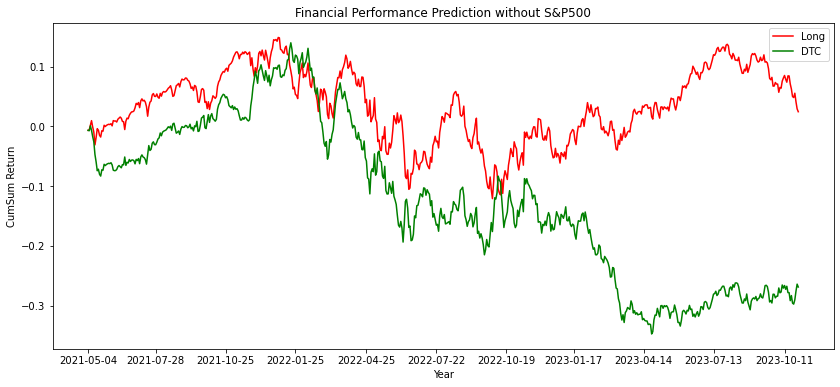

(             in sample  out of sample
Classifiers                          
DTC           0.577109       0.307568,           Long       DTC
1862 -0.006678 -0.006678
1863 -0.005977 -0.007378
1864  0.002186  0.000785
1865  0.009563 -0.006592
1866 -0.000872 -0.017027
...        ...       ...
2478  0.048175 -0.297348
2479  0.055441 -0.290081
2480  0.041105 -0.275745
2481  0.029276 -0.263916
2482  0.024477 -0.268714

[621 rows x 2 columns])


In [113]:
results = decision_tree_classifier(dataframe, currencies=['USDblo', 'USDJPY', 'USDEUR', 'USDGBP'],include_sp500=False, lag=1, max_depth=5)
print(results)